In [16]:
import sys
sys.path.append("/home/hd/hd_hd/hd_gu452/MeanFlow/")
from sit import SiT_models
import torch
import matplotlib.pyplot as plt
import numpy as np
from diffusers.models import AutoencoderKL
from meanflow_sampler import meanflow_sampler


device = "cuda" if torch.cuda.is_available() else "cpu"

In [5]:
model = SiT_models['SiT-B/4'](
    input_size=256//8,
    num_classes=1000,
    use_cfg=False,
    fused_attn=False,
    qk_norm=False,
)

In [12]:
chkpt = torch.load("../GenerativeModels/sit_b_4_meanflow_wocfg_ema.pt")
model.load_state_dict(chkpt)
model.to(device)

SiT(
  (x_embedder): PatchEmbed(
    (proj): Conv2d(4, 768, kernel_size=(4, 4), stride=(4, 4))
    (norm): Identity()
  )
  (t_embedder): TimestepEmbedder(
    (mlp): Sequential(
      (0): Linear(in_features=256, out_features=768, bias=True)
      (1): SiLU()
      (2): Linear(in_features=768, out_features=768, bias=True)
    )
  )
  (r_embedder): TimestepEmbedder(
    (mlp): Sequential(
      (0): Linear(in_features=256, out_features=768, bias=True)
      (1): SiLU()
      (2): Linear(in_features=768, out_features=768, bias=True)
    )
  )
  (y_embedder): LabelEmbedder(
    (embedding_table): Embedding(1001, 768)
  )
  (blocks): ModuleList(
    (0-11): 12 x SiTBlock(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=False)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_featu

In [13]:
vae = AutoencoderKL.from_pretrained(f"stabilityai/sd-vae-ft-ema").to(device)

In [25]:
@torch.no_grad()
def sample(model, vae, num_samples):
    latent_size = 32    
    z = torch.randn(num_samples, model.in_channels, latent_size, latent_size, device=device)
    y = torch.randint(0, 1000, (num_samples,), device=device)

    # Sample images using MeanFlow:
    samples = meanflow_sampler(
        model=model, 
        latents=z,
        y=y,
        num_steps=200,
    ).to(torch.float32)
    latents_scale = torch.tensor(
        [0.18125, 0.18125, 0.18125, 0.18125]
        ).view(1, 4, 1, 1).to(device)
    latents_bias = torch.tensor(
        [0., 0., 0., 0.]
        ).view(1, 4, 1, 1).to(device)
    samples = vae.decode((samples -  latents_bias) / latents_scale).sample
    return samples

In [26]:
samples = sample(model, vae, 10)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.3232317..1.3288059].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.058675945..1.0103909].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.26468778..1.2679964].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0016971827..1.0191936].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.07656878..1.0479991].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.12807536..1.1197324].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-

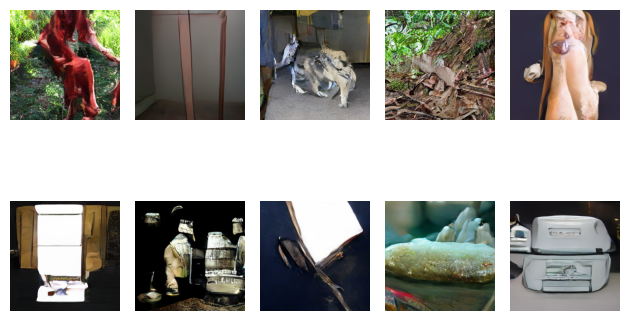

In [27]:
for i in range(2):
    for j in range(5):
        plt.subplot(2, 5, i*5+j+1)
        plt.imshow(samples[i*5+j].permute(1, 2, 0).cpu().detach().numpy()/2 + 0.5)
        plt.axis("off")

plt.tight_layout()

plt.show()